First, let's import some packages that will help us do things.

In [297]:
import matplotlib.pyplot as plt  #A plotting package so that we can see the B field
import numpy as np               #A package to help with arrays
import itertools                 #Allows us to take the product of lists
from __future__ import division  #If you are using python2, this makes 2/3=0.6666 instead of 0
import math                      #math functions, like math.floor,ceil,...

In this code, we will be dealing with vectors extensively. So why don't we define a 'class' for vector (essentially a way to represent vectors in code)

In [298]:
class vector():
    
    #Whenever we are defining a class, we need an 'init' statement that tells us how to create
    # a member of the class. In this case, to create a vector we need a list of coordinates
    # telling us where the vector is. Class functions usually will come with a first argument
    # 'self' - self is essentially 'the object itself'. This may be confusing - you can 
    # ignore these kinds of intricacies for now. 
    def __init__(self,coord):
        #Here, in the init statement, we set some 'properties' of the vector.
        #The coordinates of the vector are given by the coordinates we feed. 
        self.coord = coord
        
        #And the dimension of the vector is defined to be the length of the coordinate list.
        self.dim   = len(coord)
        
    #The special function __repr__ is the 'representation' of the vector.
    #For example, if we try to print a vector, then without a special __repr__ function it will
    #just print something like "instance of a vector". With a __repr__ function, it will instead
    #print whatever useful information __repr__ returns.
    def __repr__(self):
        return 'Vector with coordinates:' + str(self.coord)
    
    #__getitem__ is uesful, in that vector[i] is not vector.coord[i] (the i-th coordinate)
    def __getitem__(self,i):
        return self.coord[i]
    
    #__add__ is used if I call v1+v2 where v1,v2 are vectors. In essence, I am telling my python code
    # how do two vectors add? 
    def __add__(self,other):
        #I need to assert that the dimensions of the two vectors are the same, otherwise how can 
        #their addition make sense? If this assert fails, then python will throw an error.
        assert (self.dim == other.dim) 
        c1 = self.coord; c2 = other.coord;
        #In my code, I'll use a lot of shorthand like the following line to do things.
        """Given that I'm adding vectors componentwise - can you read the following line of code?"""
        return vector([c1[x]+c2[x] for x in range(self.dim)])
    
    #A function for v1-v2
    def __sub__(self,other):
        assert (self.dim == other.dim)
        c1 = self.coord; c2 = other.coord;
        return vector([c1[x]-c2[x] for x in range(self.dim)])
    
    #A function for v/c where v is a vector and c is a constant
    def __truediv__(self,other):
        c = self.coord;
        return vector([c[x]/other for x in range(self.dim)])
    
    #A function for v*c where v is a vector and c is a constant
    def __mul__(self,other):
        c = self.coord;
        return vector([c[x]*other for x in range(self.dim)])
        
    #A function for v1 x v2 (the cross product of two vectors)
    def cross(self,other):
        #We need that the vectors are both 3-dimensional for cross product to make sense!
        assert (self.dim == 3 and other.dim == 3)
        
        c1 = self.coord; c2 = other.coord;
        return vector([c1[1]*c2[2]-c1[2]*c2[1],
                       c1[2]*c2[0]-c1[0]*c2[2],
                       c1[0]*c2[1]-c1[1]*c2[0]])
    
    #The dot product of two vectors
    def dot(self,other):
        #Once again they need to be the same dimension!
        assert (self.dim == other.dim)
        
        c1 = self.coord; c2 = other.coord;
        return sum([c1[x]*c2[x] for x in range(self.dim)])
    
    #The norm a vector
    def norm(self):
        """Can you figure out how the following line of code returns the norm of the vector?"""
        return (self.dot(self))**(1/2)

We can play around with vectors to make sure everything is working as expected:

In [301]:
#Defining a vector:
v1 = vector([1,5,-1])
print(v1)
print('norm:',v1.norm())
print('scalar multiplication:',v1*2)
print('scalar division:',v1/2)

#Now, lets check the other things
v2 = vector([5,3,2])
print('addition:',v1+v2)
print('subtraction:',v1-v2)
print('cross:',v1.cross(v2))
print('dot:',v1.dot(v2))

print('Everything works! yay!')

Vector with coordinates:[1, 5, -1]
('norm:', 5.196152422706632)
('scalar multiplication:', Vector with coordinates:[2, 10, -2])
('scalar division:', Vector with coordinates:[0.5, 2.5, -0.5])
('addition:', Vector with coordinates:[6, 8, 1])
('subtraction:', Vector with coordinates:[-4, 2, -3])
('cross:', Vector with coordinates:[13, -7, -22])
('dot:', 18)
Everything works! yay!


Now, let's write a Biot-Savart function that will return the magnetic field at a point given a certain current configuration.

In [302]:
def biot_savart_2D(current,L,N,C):
    #For now, let's assume that current is a list of vectors specifying the curve along which current flows.
    #This function will be computing the B field in the -L < x,y < L box around the origin.
    #Space is discretised into pixels the size of L/N
    """What happens to the magnetic field very close to a wire carrying current?"""
    #If you think about the above, you realise there is a problem! There are two ways to fix this,
    #introduce finite wire-thickness (kind of annoying), or just simply place a cap C on the maximum
    #magnetic field allowed. 
    
    #we need to find the sequence of infinitessimal length elements dl. We use a trick:
    dl = np.roll(current,-1) - current
    #Initialize our B field to zero:
    B_field = np.zeros((N,N)).tolist()
    #More tricks: itertools.product allows us to take the cartesian product of lists. In this case,
    #this is equivalent to x_i,y_i being in two nested for loops ranging from 0 ... N-1
    for (x_i,y_i) in itertools.product(range(N),repeat=2):
        #We want to convert our indices to spatial coordinates (more tricks)
        x = np.linspace(-L,L,N)[x_i]
        y = np.linspace(-L,L,N)[y_i]
        #Now, using the position vector, we can find the sequence of relative position vectors r_prime
        r = vector([x,y,0])
        r_prime = [r - c for c in current]
        
        #And with some tricks, implement the biot-savart law. 
        B = reduce(lambda x,y : x+y,
                    [dl[i].cross(r_prime[i])/((r_prime[i].norm())**3) for i in range(len(current))])
        
        #If our B field is too large, we want to clip it:
        if B.norm() > C:
            B = (B/B.norm())*C
        B_field[x_i][y_i] = B
    return B_field

Now, let's write some code to generate a loop of current

In [303]:
def loop(center,axis1,axis2,N):
    """A lot of my code is just a bunch of 'tricks' to do things quickly. 
    If you want, you can think about how the following line generates a 'loop' of vectors,
    but its not all that important. The loop is centered at the vector 'center', and 
    lies in the plane spanned by axis1 and axis2 centered at 'center'."""
    return [center+axis1*np.cos(theta)+axis2*np.sin(theta) for theta in np.linspace(0,2*np.pi,N)[:-1]]

Now, let's write some code to put it all together and plot the B-field distribution

In [304]:
def plot_B(B_field,L,W,N):
    #Here is some code to plot the B_field. roughly speaking:
    # L : the length of the arrows
    # W : the width of the arrows
    # N : the number of arrows
    
    #You can change the colorscheme if you want, I didn't put too much time into making the plots
    #look aesthetic. To do so, you need to change the 'cmap' and the 'color' argument
    plt.figure(figsize=(8,8))
    plt.imshow(np.array([[np.log(B.norm()) for B in row] for row in B_field]).T,cmap='plasma')
    plt.colorbar()
    
    for (x_i,y_i) in itertools.product(range(N),repeat=2):
        B = B_field[int(len(B_field)*(x_i/N))][int(len(B_field)*(y_i/N))]
        plt.arrow((x_i/N)*len(B_field),(y_i/N)*len(B_field),
                  L*(B[0]/B.norm())*np.tanh(B.norm()),
                  L*(B[1]/B.norm())*np.tanh(B.norm()),width=W,color='black')
    
    plt.show()

calculating current loop...
calculating B field...
plotting...


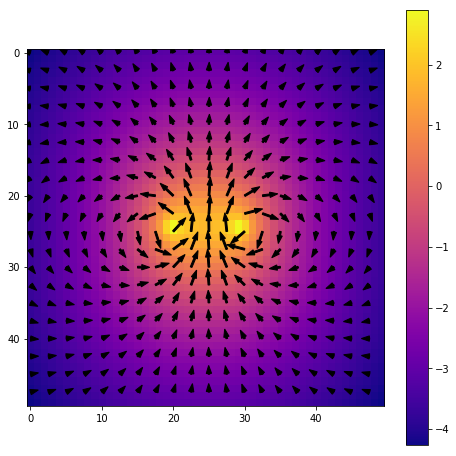

In [305]:
#Let's look at the field generated by a single loop of current!
#The color is log(B), and the arrows are along the direction of B
#I probably made some sign mistakes in my code; so maybe the arrows need to be flipped.

print('calculating current loop...')
I = loop(vector([0,0,0]),vector([1,0,0]),vector([0,0,1]),50)

print('calculating B field...')
B = biot_savart_2D(I,5,50,20.)

print('plotting...')
plot_B(B,1.5,0.25,20)

calculating current loop...
calculating B field...


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars


plotting...


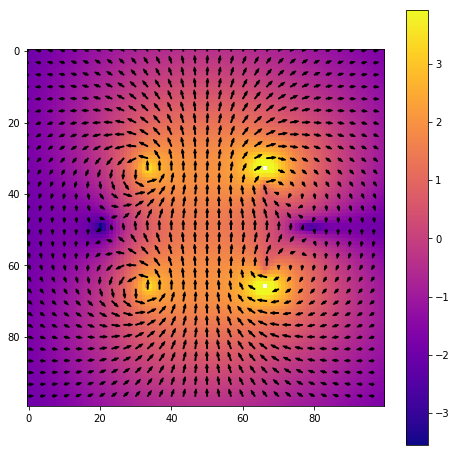

In [306]:
#Let's look at the field generated by two loops!

print('calculating current loop...')
I = loop(vector([0,-1,0]),vector([1,0,0]),vector([0,0,1]),50) + \
    loop(vector([0, 1,0]),vector([1,0,0]),vector([0,0,1]),50)

print('calculating B field...')
B = biot_savart_2D(I,3,100,50.)

print('plotting...')
plot_B(B,1.5,0.25,30)

In [ ]:
"""
Things to think about:
 - What are the bright spots in the picture representing?
 - Note the field looks more uniform with two wires! What happens in the limit of many many loops of wire
forming a solenoid? Can you simulate this?
 - We have some theoretical predictions of the B field along the axis and far away from the axis of the 
single loop of wire. Can you verify these using simulation+plots?
 
 - Ultimate question: Can you simulate a tokamak?
"""